In [44]:
import geopandas
from shapely import Polygon


import os
import wget
import zipfile


from openai import OpenAI

In [7]:

def download_national_parks_data(
        url_path: str = "https://opendata.arcgis.com/datasets/beb04b0e5bed44da9e5407ea50477a5c_0.zip",
        output_directory_base: str = "../data/parques_nacionales",
        raw_data: str = '../data/raw',
        name: str = "data_parques"
) -> str:
    """
    Download the national parks data from the url_path and save it in the output_directory_base
    """
    if not os.path.exists(output_directory_base):
        os.makedirs(output_directory_base, exist_ok=True)

    if not os.path.exists(raw_data):
        os.makedirs(raw_data, exist_ok=True)

    # Download the data
    output_directory = wget.download(url_path, out=raw_data)
    # Unzip the data
    with zipfile.ZipFile(output_directory, 'r') as zip_ref:
        zip_ref.extractall(output_directory_base)

    for file in os.listdir(output_directory_base):
        os.rename(
            os.path.join(output_directory_base, file), 
            os.path.join(output_directory_base, name + os.path.splitext(file)[1])
        )
    return output_directory_base

In [8]:
name = "data_parques"
output_directory_base = download_national_parks_data(name=name)

# Load files
df = geopandas.read_file(
    os.path.join(output_directory_base, name + ".shp")
)

In [36]:
df_demo = geopandas.read_file(
    "../data/demo_data/doc.kml"
)

In [78]:
df_kms = df.to_crs("EPSG:32633")
demo_geometry_kms = df.to_crs("EPSG:32633")

In [85]:
distance = df_kms.geometry.distance(demo_geometry_kms.iloc[0].geometry)/1000

In [86]:
distance

0         0.000000
1      1600.414581
2      3896.123523
3      3175.903880
4       135.100850
          ...     
636    2006.109524
637      97.955376
638     100.572776
639     182.414866
640    3274.280964
Length: 641, dtype: float64

<Axes: >

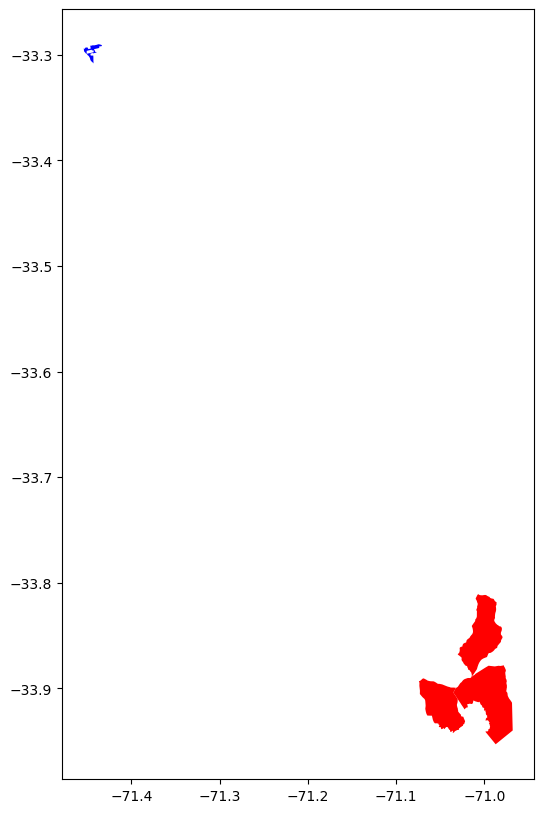

In [81]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
df[distance < 3].plot(ax=ax, color="red")
df_demo.plot(ax=ax, color="blue")

In [ ]:
class NationalParkAssistant:

    def __init__(self, df: geopandas.GeoDataFrame):
        self.df = df

    def system_prompt(self) -> str:
        
        
        system_prompt = """
        Eres un experto en parques nacionales y te han contratado para hacer la evaluación de impacto ambiental
        de un nuevo proyecto fotovoltaico en Chile.

        El usuario entregará su locacion y los parques nacionales cercanos en un radio de 3km.

        Tu trabajo es entregar una detallada evaluación de impacto ambiental del proyecto fotovoltaico en los parques nacionales cercanos.

        Para esto primero vas a entregar un resumen si encuentras algo critico, para rechazar el proyecto, si no di que todo esta bien.

        En caso de que encuentres algo critico, debes entregar una evaluación detallada de los impactos ambientales y sociales del proyecto.

        El output será un JSON con dos campos
        ```json
        {
            "resumen": "El proyecto fotovoltaico tiene un impacto ambiental critico en el parque nacional Torres del Paine",
            "evaluacion": "El proyecto fotovoltaico tiene un impacto ambiental critico en el parque nacional Torres del Paine debido a la alta concentración de aves en la zona"}
        }
        ```
        """
        return system_prompt

    def evaluate_project(self, location: Polygon) -> dict:
        distance = self.df.geometry.distance(location)
